<a href="https://colab.research.google.com/github/AnnetVasileva/machineLearning/blob/main/Practical%202/Model_RF_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, matthews_corrcoef, plot_roc_curve, confusion_matrix
from sklearn.svm import SVC

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)
  auc_score = sklearn.metrics.roc_auc_score(labels, predictions)
  line_name =  name+ ', AUC: ' + str(round(auc_score,4))
  plt.plot(100*fp, 100*tp, label= line_name,
           linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,100])
  plt.ylim([0,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')
  #plt.plot([0, 100], [0, 100], linestyle='--', lw=2, color='r',
  #      label='Chance', alpha=.8)
  
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [ ]:
# read in data
path = '/content/drive/MyDrive/ML_ECO/'
pickle_file = 'data_set_big.pkl'

with open(path + pickle_file, 'rb') as f:
  train_set =pickle.load(f) 

X = train_set['X']
y = train_set['y']
X.shape

(111680, 174)

In [ ]:
# split data
X_train, X_test, y_train, y_test = train_test_split( X, y, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    stratify = y)


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
oob_score= [True, False]
# Create the random grid
random_grid = {'n_estimators': [500],
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'bootstrap': bootstrap,
               'oob_score': oob_score}
print(random_grid)


{'n_estimators': [500], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, None], 'min_samples_split': [2, 5, 10], 'bootstrap': [True, False], 'oob_score': [True, False]}


In [ ]:
rf_basic=RandomForestClassifier(random_state=42, n_jobs = -1)
rf_random = RandomizedSearchCV(estimator = rf_basic, param_distributions = random_grid, n_iter = 10, cv = 2, verbose=10, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 17.8min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 26.9min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 39.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 39.3min finished


RandomizedSearchCV(cv=2, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight='balanced',
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
         

In [ ]:
y_pred_base = rf_random.best_estimator_.predict_proba(X_test)[:,1]
y_base_labels = 1*(y_pred_base>0.5)

In [ ]:
def print_score(labels, pred):
  accuracy  = accuracy_score(labels,pred)
  precision = precision_score(labels, pred)
  recall = recall_score(labels,pred)
  print('Accuracy : {}'.format(accuracy),
        '\nPrecision {}:'.format(precision),
        '\nRecall: {}'.format(recall))

In [ ]:
print_score(y_test, y_base_labels)

Accuracy : 0.9470809455587392 
Precision 0.0: 
Recall: 0.0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
confusion_matrix(y_test, y_base_labels)

array([[21154,     0],
       [ 1182,     0]])

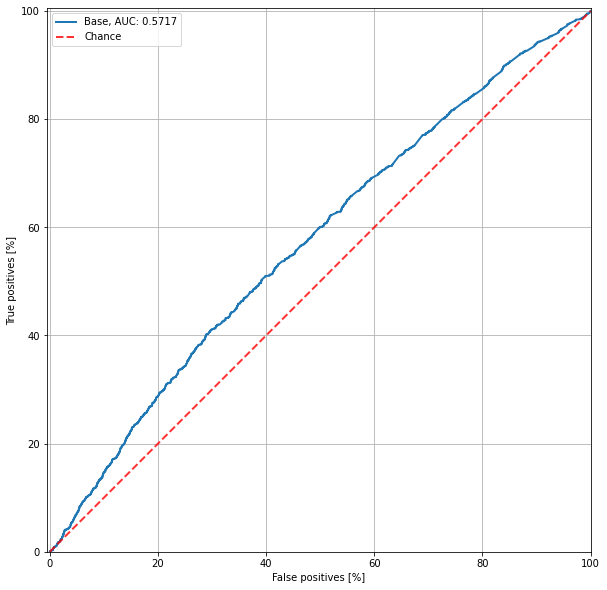

In [ ]:
plot_roc('Base', y_test, y_pred_base)
plt.plot([0, 100], [0, 100], linestyle='--', lw=2, color='r',
      label='Chance', alpha=.8)
plt.legend()

OVERSAMPLING


In [ ]:
# UNDERSAMPLING MODEL
undersample = RandomUnderSampler(sampling_strategy='majority')
# fit and apply the transform
X_under, y_under = undersample.fit_resample(X_train, y_train)

random_grid_under = {'n_estimators': [200,300,500,750],
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'bootstrap': bootstrap,
               'oob_score': oob_score}

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
rf_undersample = RandomForestClassifier(random_state=42, n_jobs = -1)
rf_under = RandomizedSearchCV(estimator = rf_undersample, param_distributions = random_grid_under, n_iter = 20, cv = 3, verbose=10, random_state=42, n_jobs = -1)

# Fit the random search model
rf_under.fit(X_under, y_under)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   54.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  6.7min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [ ]:
rf_under.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
y_pred_under = rf_under.best_estimator_.predict_proba(X_test)[:,1]
y_under_labels = 1*(y_pred_under > 0.5)

In [ ]:
print_score(y_test, y_under_labels)

Accuracy : 0.5641565186246418 
Precision 0.07084796788760662: 
Recall: 0.5972927241962775


In [ ]:
confusion_matrix(y_test, y_under_labels)

array([[11895,  9259],
       [  476,   706]])

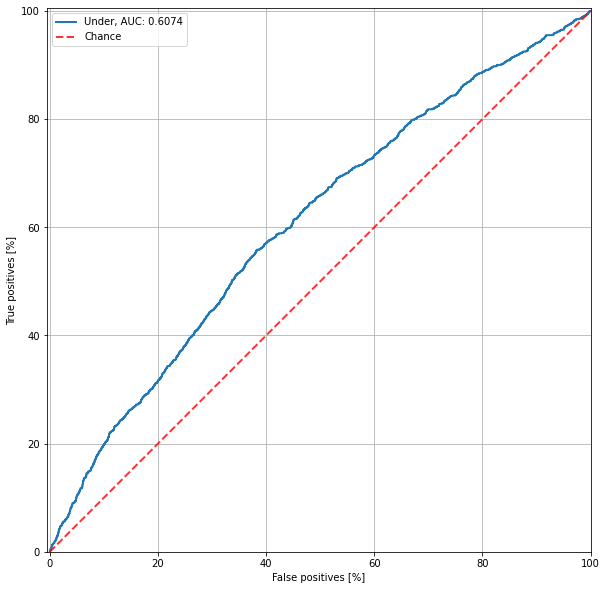

In [ ]:
plot_roc('Under', y_test, y_pred_under)
plt.plot([0, 100], [0, 100], linestyle='--', lw=2, color='r',
      label='Chance', alpha=.8)
plt.legend()

In [ ]:
#OVERSAMPLING
# UNDERSAMPLING MODEL
oversample = RandomOverSampler(0.2)
# fit and apply the transform
X_over, y_over = oversample.fit_resample(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
Counter(y_train)

Counter({0: 84614, 1: 4730})

In [ ]:
from collections import Counter
Counter(y_over)

Counter({0: 84614, 1: 16922})

In [ ]:
rf_oversample = RandomForestClassifier(random_state=42, n_jobs = -1)
rf_over = RandomizedSearchCV(estimator = rf_oversample, param_distributions = random_grid_under, n_iter = 10, cv = 2, verbose=10, random_state=42, n_jobs = -1)

# Fit the random search model
rf_over.fit(X_over, y_over)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 18.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 18.3min finished


RandomizedSearchCV(cv=2, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [ ]:
rf_over.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
y_pred_over = rf_over.best_estimator_.predict_proba(X_test)[:,1]
y_over_labels = 1*(y_pred_over > 0.5)

In [ ]:
print_score(y_test, y_over_labels)

Accuracy : 0.9465436962750716 
Precision 0.07142857142857142: 
Recall: 0.0008460236886632825


In [ ]:
confusion_matrix(y_test, y_over_labels)

array([[21141,    13],
       [ 1181,     1]])

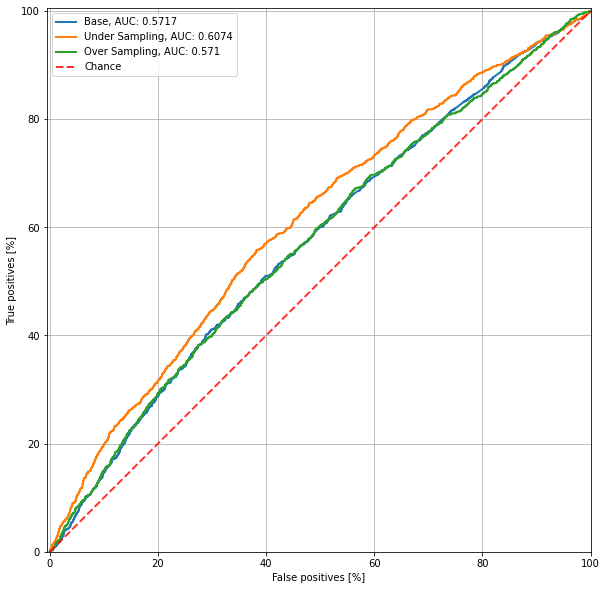

In [ ]:
plot_roc('Base', y_test, y_pred_base)
plot_roc('Under Sampling', y_test, y_pred_under)
plot_roc('Over Sampling', y_test, y_pred_over)
plt.plot([0, 100], [0, 100], linestyle='--', lw=2, color='r',
      label='Chance', alpha=.8)
plt.legend()